# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [4]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors

## Load data

Define the range of possible coefficient values to explore.

In [5]:
coefficients = np.linspace(-3, 3, 21)

In [6]:
delta_time = 1.0
l1_lambda = 0.001

In [7]:
last_timepoint = pd.to_datetime("2014-10-01")

In [8]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [9]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ne", "delta_frequency", "frequency"]].copy()

In [10]:
X = X[X["timepoint"] <= last_timepoint]

In [11]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ne,delta_frequency,frequency
0,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.480228,-0.751835,9,6,-1.070555,0.003256
1,A/Aichi/183/2004,e5a7ac4,2004-10-01,0.480228,-0.702596,10,6,-1.070555,0.003087
2,A/Anhui/789/2004,66684e0,2004-10-01,-1.076234,-1.059483,11,8,-0.860003,0.003449
3,A/Argentina/126/2004,e5a7ac4,2004-10-01,0.479267,-0.603165,10,7,-1.070555,0.004187
4,A/Argentina/26/2004,2f64328,2004-10-01,-0.235321,-1.154832,7,8,-2.266965,0.002362


In [12]:
X.shape

(6578, 9)

In [13]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [14]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,e5a7ac4,2005-10-01,A/RioGrandeDoSul/290/2005,0.002219
1,2004-10-01,e5a7ac4,2005-10-01,A/Thailand/44/2005,0.000074
2,2004-10-01,66684e0,2005-10-01,NaN,0.000000
3,2004-10-01,2f64328,2005-10-01,NaN,0.000000
4,2004-10-01,8f3fc76,2005-10-01,A/Hanoi/ISBM16/2005,0.000778


In [15]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

In [16]:
y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

In [17]:
y = y[y["timepoint"] <= last_timepoint]

In [18]:
y.head()

,timepoint,clade_membership,frequency
0,2004-10-01,2f64328,0.000000
1,2004-10-01,66684e0,0.000000
2,2004-10-01,84dfd90,0.000227
3,2004-10-01,8f3fc76,0.018687
4,2004-10-01,dffb0cc,0.000000


In [19]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2004-10-01    0.964599
2005-04-01    0.998802
2005-10-01    1.000009
2006-04-01    0.999998
2006-10-01    0.999997
2007-04-01    1.000000
2007-10-01    1.000002
2008-04-01    0.999994
2008-10-01    1.000001
2009-04-01    0.999998
2009-10-01    0.999994
2010-04-01    0.999995
2010-10-01    0.999990
2011-04-01    0.999991
2011-10-01    0.991572
2012-04-01    0.999686
2012-10-01    0.995549
2013-04-01    0.999946
2013-10-01    1.000004
2014-04-01    1.000002
2014-10-01    0.999980
Name: frequency, dtype: float64

## Inspect LBI model

In [20]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [21]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

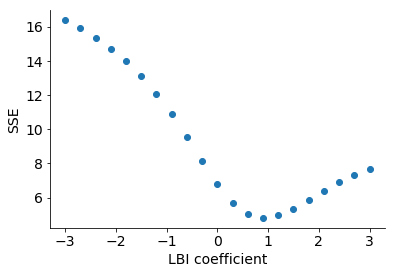

In [22]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

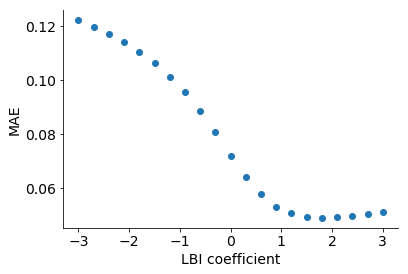

In [23]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

## Inspect cTiterSub model

In [24]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [25]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

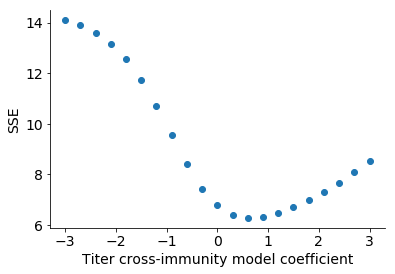

In [26]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

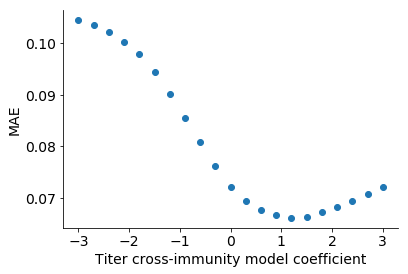

In [27]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [28]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [29]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

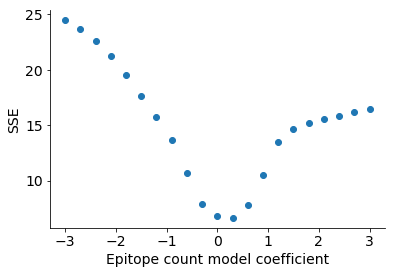

In [30]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

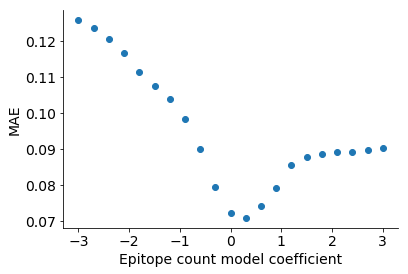

In [31]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect delta frequency model

In [32]:
predictors = ["delta_frequency"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

In [33]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'MAE')

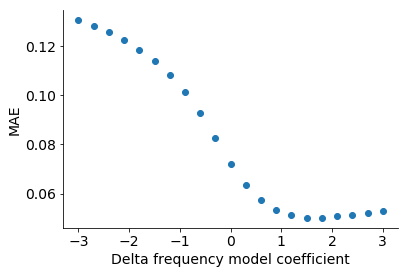

In [34]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [35]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [36]:
len(coefficients)

21

In [37]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

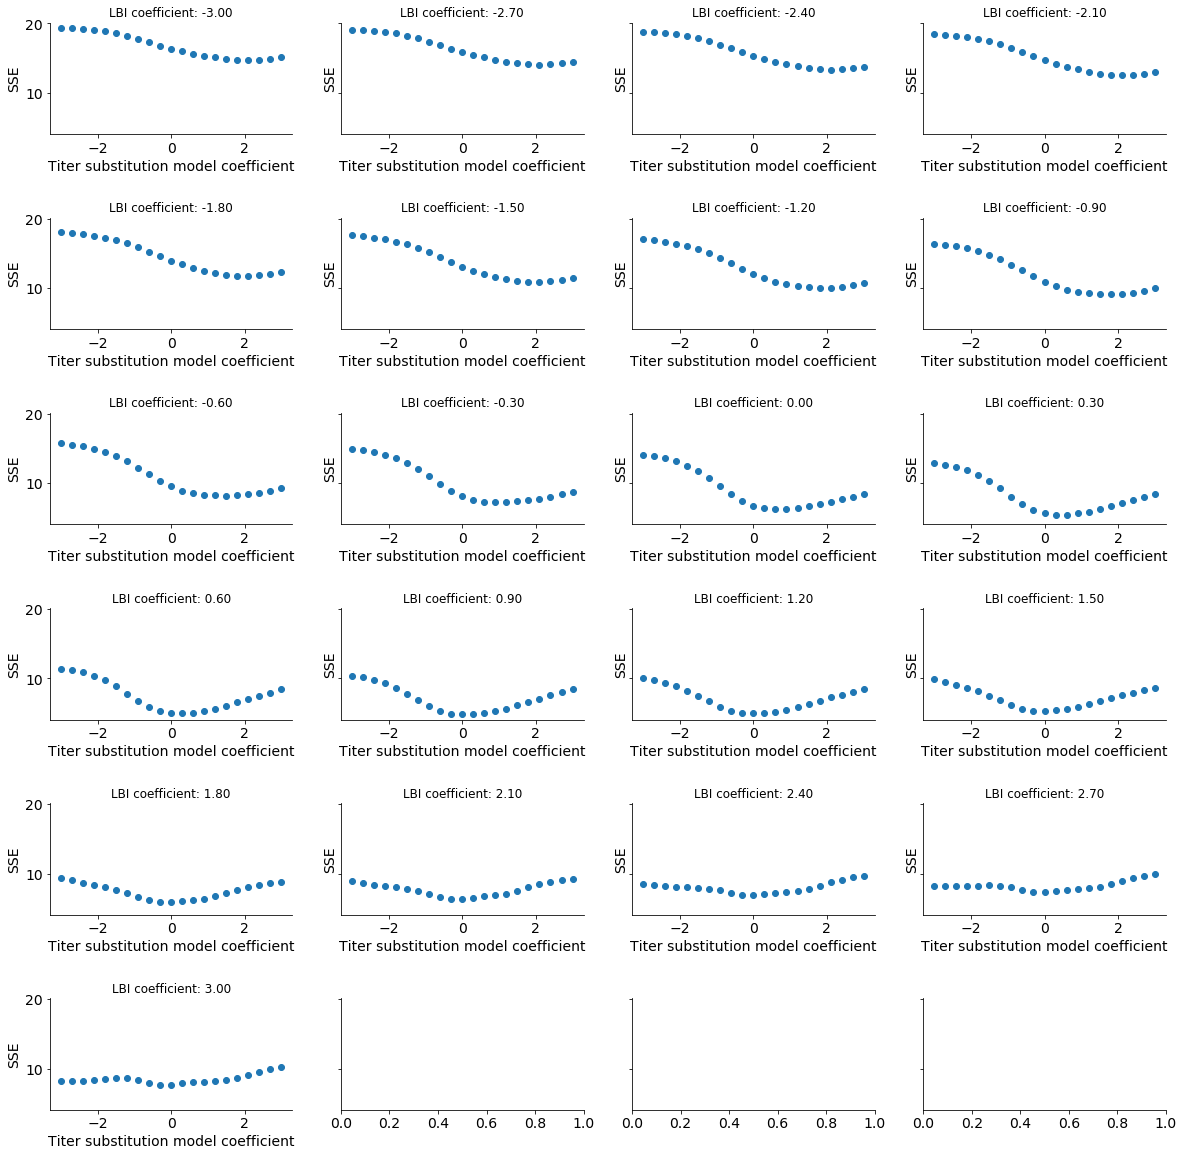

In [38]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [39]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [40]:
records_df = pd.DataFrame(records)

In [41]:
records_df.sort_values("error").head()

,cTiterSub,error,lbi
367,0.0,0.047191,2.1
346,0.0,0.047313,1.8
388,0.0,0.047514,2.4
366,-0.3,0.047576,2.1
368,0.3,0.047671,2.1


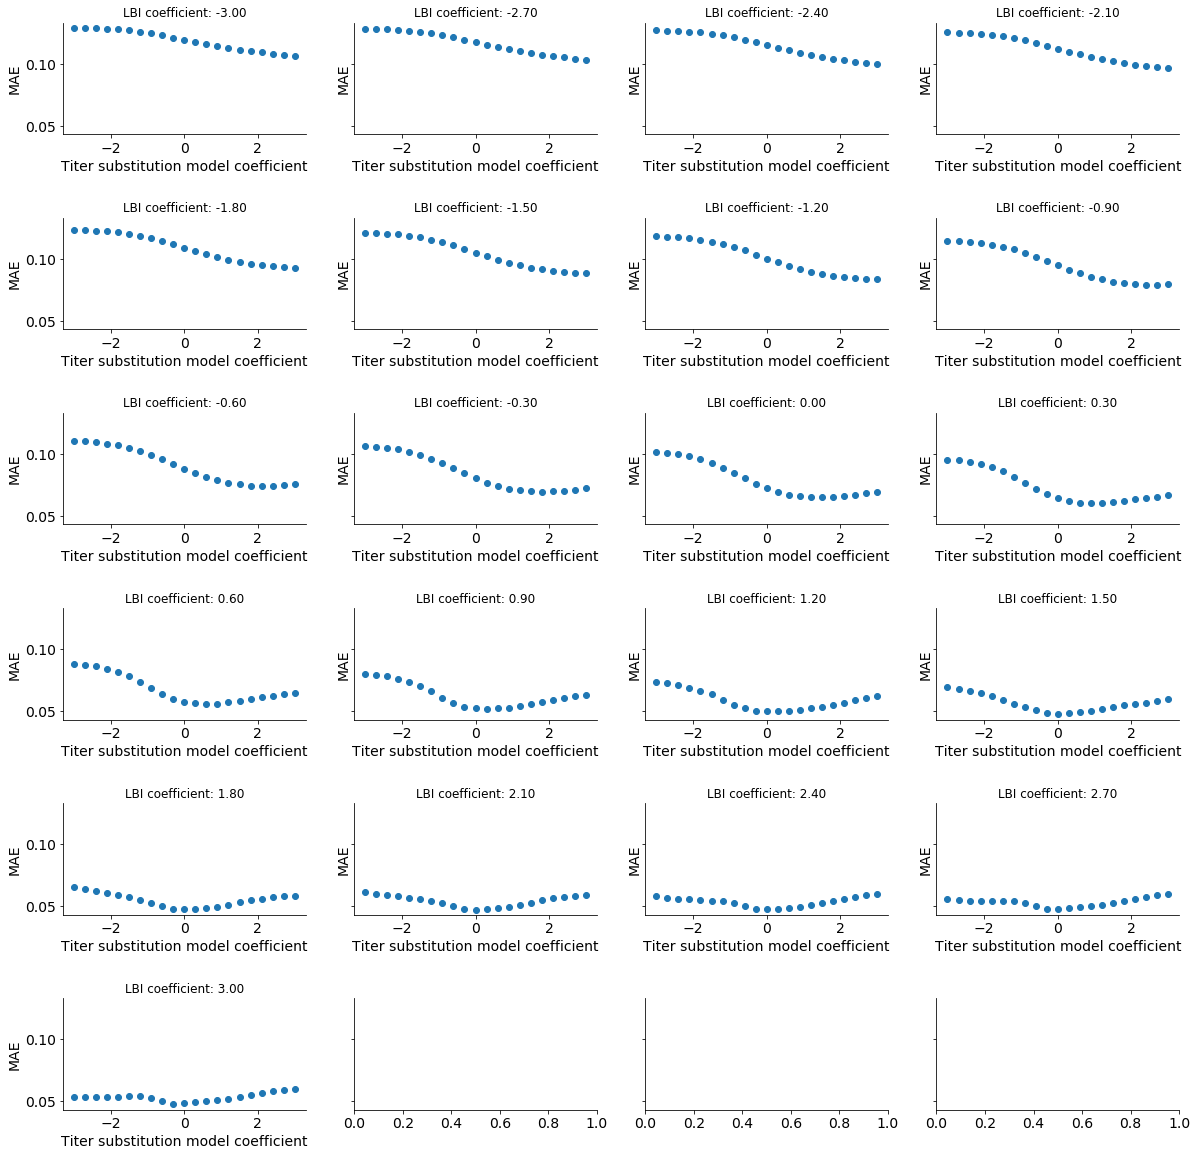

In [42]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)